In [1]:
%gui qt5
# Note that this Magics command needs to be run in a cell
# before any of the Napari objects are instantiated 
#(before starting viewer) to ensure it has time to 
# finish executing before they are called (few seconds)

In [2]:
import time

In [3]:
import numpy as np
from skimage import io, filters, feature, measure, morphology, util
import matplotlib.pyplot as plt
from skimage.draw import polygon
import alphashape
from joblib import Parallel, delayed
from sklearn.neighbors import KDTree

In [4]:
from scipy import ndimage

In [5]:
import napari

In [6]:
img = io.imread("Data/2xfts_RD_4DFed_1DS_1.tif")

### We are going to select whick channel to work with - Starting with the DAPI channel

In [7]:
DAPI = img[:,0,:,:]

We creating a max intensity projection of DAPI to select our ROI

In [8]:
mip_dapi = np.amax(DAPI, axis=0)

We are using napari to create a ROI:
We add "new shape layer"
then we use "add paths"

In [9]:
viewer = napari.view_image(mip_dapi)

In [11]:
mask = np.zeros(mip_dapi.shape, dtype = np.bool)
rr, cc = polygon(viewer.layers[1].data[0][:,0], viewer.layers[1].data[0][:,1], mask.shape)
mask[rr, cc] = 1

Adding the mask we just created

In [12]:
viewer.add_image(mask, opacity = 0.5)

/Applications/anaconda3/envs/aparna/lib/python3.7/site-packages/vispy/visuals/markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])


<Image layer 'Image [1]' at 0x12c6a3128>

We now mask our ROI

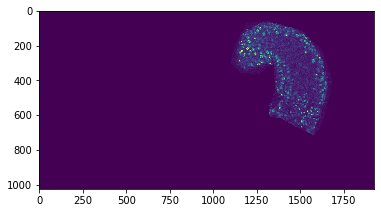

In [13]:
mask_3D = np.zeros(DAPI.shape, dtype = np.bool) 
mask_3D[:] = mask
DAPI[~mask_3D] = 0
plt.imshow(DAPI[20])

Create a bounding box around our ROI

In [14]:
bbox = ndimage.find_objects(mask_3D)
DAPI_roi = DAPI[bbox[0]]

In [15]:
viewer = napari.Viewer(ndisplay=2)
viewer.add_image(DAPI_roi, name="DAPI")

<Image layer 'DAPI' at 0x131af8438>

In [16]:
from skimage.external.tifffile import TiffFile
import re

with TiffFile("Data/2xfts_RD_4DFed_1DS_1.tif") as tif:
    meta = tif.info()

metadata = {}
for line in meta.splitlines():
    _, _, key_x = line.partition('x_resolution (2I)')
    _, _, key_y = line.partition('y_resolution (2I)')
    _, _, key_z = line.partition('spacing:')
    _, _, key_unit = line.partition('unit:')
    if key_x:
        x_data = [int(x.group()) for x in re.finditer(r'\d+', key_x)]
        x_resolution = 1/(x_data[0]/x_data[1])
        metadata['x_resolution'] = x_resolution
    if key_y:
        y_data = [int(x.group()) for x in re.finditer(r'\d+', key_y)]
        y_resolution = 1/(y_data[0]/y_data[1])
        metadata['y_resolution'] = y_resolution
        
    if key_z:
        metadata['z_resolution'] = float(key_z)
    if key_unit:
        metadata['unit'] = key_unit

In [17]:
# The microscope reports the following spacing
original_spacing = np.array([metadata['z_resolution'], metadata['x_resolution'], metadata['y_resolution']])

In [18]:
base_sigma = 2.0

sigma = base_sigma / original_spacing

gaussian_to_seg = filters.gaussian(DAPI_roi, multichannel=False, sigma=sigma)

In [19]:
viewer.add_image(gaussian_to_seg, name="DAPI_Blured")

<Image layer 'DAPI_Blured' at 0x131d64898>

In [20]:
def roll_ball(img, size =20):
    result = np.empty(img.shape)
    # Background substraction
    background = ndimage.minimum_filter(img, size = 8)
    result = img-background
    return(result)

In [21]:
back_sub = roll_ball(gaussian_to_seg)

In [22]:
threshold_triangle = filters.threshold_triangle(back_sub)
binary_DAPI = back_sub > threshold_triangle

In [23]:
viewer.add_labels(binary_DAPI, name = "binary")

<Labels layer 'binary' at 0x131b31710>

In [24]:
def create_mask(binary_data, slices = 0):
    result = np.zeros(binary_data[slices].shape)
    
    coord_x, coord_y = np.where(binary_data[slices]>0)  
    lst_pts = np.concatenate((coord_x[:, np.newaxis], coord_y[:, np.newaxis]), axis=1)
        
    alpha_shape = alphashape.alphashape(lst_pts[::16], 0.1)
    
    if alpha_shape.type == 'MultiPolygon':
        for alpha in alpha_shape:
            if alpha.area > 20000:
                x, y = alpha.exterior.coords.xy
                rr, cc = polygon(np.asarray(x, dtype=np.int),np.asarray(y, dtype=np.int))
                result[rr, cc] = 1
    elif alpha_shape.type == 'GeometryCollection':
        pass

    else:
        x, y = alpha_shape.exterior.coords.xy
        rr, cc = polygon(np.asarray(x, dtype=np.int),np.asarray(y, dtype=np.int))
        result[rr, cc] = 1
    return result

Create a concave bounding box around the binary image.
This can take few minutes, depending on the number of processors on your machine. 

In [25]:
t1 = time.time()
res_paral = Parallel(n_jobs=-1)(delayed(create_mask)(binary_DAPI, slices) for slices in range(len(binary_DAPI)))
t2 = time.time()

In [26]:
t2-t1

96.69700193405151

In [27]:
mask = np.asarray(res_paral)

In [28]:
viewer.add_labels(mask)

<Labels layer 'Labels' at 0x131ac2668>

Create a border region 

In [29]:
border = mask - morphology.erosion(mask, morphology.ball(1))

In [30]:
viewer.add_labels(border)

<Labels layer 'Labels [1]' at 0x10a56ae80>

Reshape border to be [n_samples (number of pixels), n_features (number of dimension)] 

In [31]:
border_reshape = np.squeeze(np.dstack(np.where(border>0)))

Create a KDTree

In [32]:
tree = KDTree(border_reshape)

Find coordinates of the different nucleus

In [33]:
coord = feature.peak_local_max(
    gaussian_to_seg,
    threshold_abs=np.quantile(back_sub, 0.9),
    footprint=np.ones((8, 8, 8), dtype=np.bool),
    indices=True
)

Find shortest distance of these coordinates to the edge of the guts

In [34]:
distance_membrane = np.empty((len(coord), 4))
for i, coo in enumerate(coord):
    closest_dist, closest_id = tree.query(coo[np.newaxis, :] , k=1)
    distance_membrane[i,0] = closest_dist
    distance_membrane[i,1] = coo[0]
    distance_membrane[i,2] = coo[1]
    distance_membrane[i,3] = coo[2]

Creating an image with markers of nucleus color coded base on the distance to the edge of the guts

In [72]:
dist_mark = np.zeros(gaussian_to_seg.shape, dtype=np.int)
dist_mark[distance_membrane[:,1].astype(np.int), 
          distance_membrane[:,2].astype(np.int), 
          distance_membrane[:,3].astype(np.int)] = distance_membrane[:,0]+1
#dist_mark = morphology.dilation(markers, morphology.disk(5))

In [73]:
t1 = time.time()
dist_mark = morphology.dilation(dist_mark, morphology.ball(4))
dist_mark = morphology.dilation(dist_mark, morphology.ball(4))
t2 = time.time()

In [37]:
t2 - t1

16.91603136062622

In [38]:
viewer.add_image(dist_mark, colormap = 'plasma', blending = "additive")

<Image layer 'Image' at 0x145148c18>

Histogram of the result

Text(0, 0.5, 'Number of cells')

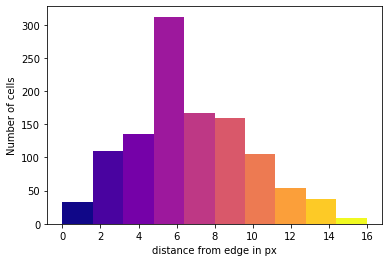

In [302]:
cm = plt.cm.get_cmap('plasma')
n, bins, patches = plt.hist(distance_membrane[:,0], color="green")

bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers) + 0.1
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
plt.xlabel('distance from edge in px')
plt.ylabel('Number of cells')

Measure intensity in different channel, base on distance to the edge

In [178]:
def measure_int_channel(dist_mark, img, bbox):
    data = []
    for i in range(1,dist_mark.max()):
        channels = []
        for ch in range(1, img.shape[1]):
            Ch_roi = img[:,ch,:,:][bbox[0]]
            dapi_label = measure.label(dist_mark==i)
            prop_ch = measure.regionprops(dapi_label, Ch_roi)
            values = []
            for prop in prop_ch:
                mean = prop.mean_intensity
                coord = prop.centroid
                values.append((i, ch, coord[0], coord[1], coord[2], mean))
            channels.append(np.asarray(values))
        data.append(np.vstack(channels))
    return np.vstack(data)

In [179]:
data = measure_int_channel(dist_mark, img, bbox)

In [151]:
import pandas as pd

In [233]:
from sklearn import preprocessing

Create a dataframe ==> csv file

In [182]:
df = pd.DataFrame(data , columns = ['Distance from edges', 'channel', 'coord z',
                                    'coord x', 'coord y', 'mean intensity'])

In [257]:
column_norm = []
for i in range(1,5):
    x = df.loc[df['channel'] == i]['mean intensity'].values
    x_v = x.reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x_v)
    column_norm.append(x_scaled)

In [263]:
df["Normalized mean intensity"] = np.vstack(column_norm)

In [283]:
df = df[['channel', 'Distance from edges', 'mean intensity', 
         'Normalized mean intensity', 'coord z', 'coord x', 'coord y']]

In [304]:
df.to_csv('/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2019/Aparna/Data/result.csv')

### Just some test after that cell

In [294]:
grouped = df.groupby(['channel'])

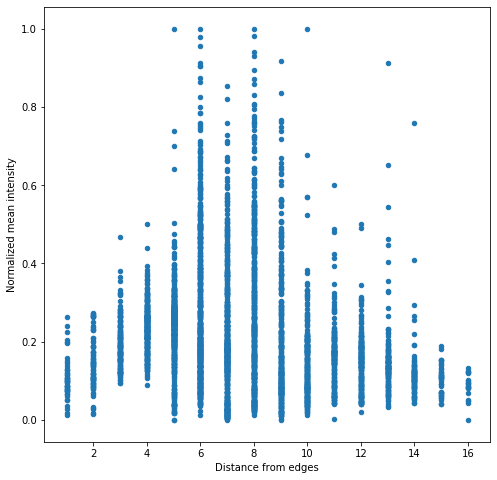

In [301]:
fig, ax = plt.subplots(figsize=(8,8))
grouped.plot(kind='scatter', x='Distance from edges', 
             y='Normalized mean intensity', style='o', ax=ax);